In [137]:
from dask.distributed import Client

client = Client("tcp://10.32.16.145:33383")
client

Client Scheduler: tcp://10.32.16.145:33383 Dashboard: /user/0000-0001-8571-865x/proxy/8787/status,Cluster Workers: 10 Cores: 20 Memory: 115.00 GB


# CMIP6 without the interpolation: Grid-native analysis with Pangeo in the cloud
*Julius Busecke*<sup>1</sup> and *Ryan Abernathey*<sup>2</sup>

(<sup>1</sup> Princeton University  <sup>2</sup> Columbia University)

The coupled model intercomparison project (CMIP; currently in its [6th iteration](https://www.geosci-model-dev.net/9/1937/2016/)) involves contribution from countries around the world, wit of xx climate models, each with numerous experiments constituting a combined dataset of of 20+ Petabyte.

Many years of planning go into the inception of the different [scenarios](), various model intercomparison projects (MIPs) and the delivery of the output data from the modeling community around the globe. A major challenge for the earth science community now, is to effectively analyze this dataset and answer science question that improve our understanding of the earth system for the coming years.

The Pangeo project recently introduced large parts of the CMIP6 data archive into the cloud **citation**. This enables, for the first time, centralized, reproducible science of state-of-the-art climate simulations without the need to own large storage or a supercomputer as a user.

The data itself however, still presents significant challenges for analysis, one of which is applying operations across many models. Two of the major hurdles are different naming/metadata between modeling centers and complex grid layouts, particularly for the ocean components of climate models.
Common workflows in the past often included interpolating/remapping desired variables and creating new files, creating organizational burden, and increasing storage requirements.

We will demonstrate two pangeo tools which enable seamless calculation of common operations like vector calculus operators (grad, curl, div) and weighted averages/integrals across a wide range of CMIP6 models directly on the data stored in the cloud. `cmip6_preprocessing` provides numerous tools to unify naming conventions and parse grid information and metrics (like cell area). This information is used by `xgcm` to enable finite volume analysis on the native model grids. The combination of both tools facilitates fast analysis while ensuring a reproducible and accurate workflow.

In [162]:
############# this wont be in the final submission ###############

## TODOs:
- remove the verbose calls from cmip6_pp, they are annoying
- integreate the decode time line in combined preprocessing
- Fix the IPSL issue (rename calendar in the files?)
- Its actually CNRM and EC earth which is messing up...weird.. I probably only need to change their calendar to a consistent one and then decode on the single dataset level
- How can I make the datasets show up in html even when I loop?
- DOI from anderson

- add tos as testvariable for the cmip6_pp cloud testing
- delete the yaml file

In [163]:
def test_distance_deg():
    assert distance_deg(0,0,0,1) == (np.array(0), np.array(1))
    assert distance_deg(0,0,1,0) == (np.array(1), np.array(0))
test_distance_deg()

In [164]:
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
import warnings
import numpy as np
import xarray as xr

def parse_bounds_vertex(da, dim='bnds', position=[0,1]):
    return tuple([da.isel({dim:position[i]}).load().data  for i in range(len(position))])

def interp_vertex_to_bounds(da, orientation):
    """
    little helper function to average 4 vertex points into two bound points. 
    Helpful to recreate e.g. the latitude at the `lon_bounds` points.
    """
    if orientation == 'x':
        datasets = [da.isel(vertex=[0,1]).mean('vertex'), da.isel(vertex=[3,2]).mean('vertex')]
    elif orientation == 'y':
        datasets = [da.isel(vertex=[0,3]).mean('vertex'), da.isel(vertex=[1,2]).mean('vertex')]
        
    return xr.concat(datasets, dim='bnds')


def distance_deg(lon0, lat0, lon1, lat1):
    Re = 6.378e6
    delta_lon = (lon1 - lon0)
    delta_lat = (lat1 - lat0)
    # very small differences can end up negative, so zero them out based on a simple criterion
    # this should work for CMIP6 (no 1/1 deg models) but should be based on actual grid info in the future
    small_crit = 1/10
    delta_lon = np.where(abs(delta_lon) < small_crit, 0.0, delta_lon)#, np.nan, delta_lon)
    delta_lat = np.where(abs(delta_lat) < small_crit, 0.0, delta_lat)#, np.nan, delta_lat)

#     # some bounds are wrapped aroud the lon discontinuty.
    delta_lon = np.where(delta_lon < (-small_crit*2) , 360+delta_lon, delta_lon)#
    delta_lon = np.where(delta_lon > (360 + small_crit*2),  -360 + delta_lon, delta_lon,)
    
    return delta_lon, delta_lat

def distance(lon0, lat0, lon1, lat1):
    Re = 6.378e6
    delta_lon, delta_lat = distance_deg(lon0, lat0, lon1, lat1)
    dy = Re * (np.pi*delta_lat/180)
    dx = Re * (np.pi* delta_lon/180) * np.cos(np.pi * lat0/180)
    return np.sqrt(dx**2 + dy**2)


def recreate_metrics(ds, grid):
    """Recreate a full set of horizontal distance metrics by using spherical geometry"""
    ds = ds.copy()
    
    #Since this puts out numpy arrays, the arrays need to be transposed correctly
    transpose_dims = ['y','x']
    dims = [di for di in ds.dims if di not in transpose_dims]
    
    ds = ds.transpose(*tuple(transpose_dims+dims))

    # is the vel point on left or right?
    axis_vel_pos = {
        axis: list(set(grid.axes[axis].coords.keys()) - set(["center"]))[0]
        for axis in ["X", "Y"]
    }
    # determine the appropriate vertex position for the north/south and east/west edge, based on the grid config
    if axis_vel_pos['Y'] in ['left']:
        ns_vertex_idx = [0,3]
    elif axis_vel_pos['Y'] in ['right']:
        ns_vertex_idx = [1,2]
        
    if axis_vel_pos['Y'] in ['left']:
        ew_vertex_idx = [0,1]
    elif axis_vel_pos['Y'] in ['right']:
        ew_vertex_idx = [3,2]
    
    
    # infer dx at tracer points
    if 'lon_bounds' in ds.coords and 'lat_verticies' in ds.coords:
        lon0, lon1 = parse_bounds_vertex(ds['lon_bounds'])
        lat0, lat1 = parse_bounds_vertex(interp_vertex_to_bounds(ds['lat_verticies'], 'x'))
        dist = distance(lon0, lat0, lon1, lat1)
        ds.coords["dx_t"] = xr.DataArray(dist, coords=ds.lon.coords)
    
    # infer dy at tracer points
    if 'lat_bounds' in ds.coords and 'lon_verticies' in ds.coords:
        lat0, lat1 = parse_bounds_vertex(ds['lat_bounds'])
        lon0, lon1 = parse_bounds_vertex(interp_vertex_to_bounds(ds['lon_verticies'], 'y'))
        dist = distance(lon0, lat0, lon1, lat1)
        ds.coords["dy_t"] = xr.DataArray(dist, coords=ds.lon.coords)
        
    if 'lon_verticies' in ds.coords and 'lat_verticies' in ds.coords:
        
        # infer dx at the north/south face
        lon0, lon1 = parse_bounds_vertex(ds['lon_verticies'], dim='vertex', position=ns_vertex_idx)
        lat0, lat1 = parse_bounds_vertex(ds['lat_verticies'], dim='vertex', position=ns_vertex_idx)
        dist = distance(lon0, lat0, lon1, lat1)
        ds.coords["dx_gy"] = xr.DataArray(dist, coords=grid.interp(ds.lon, "Y", boundary="extrapolate").coords)
        
        # infer dy at the east/west face
        lon0, lon1 = parse_bounds_vertex(ds['lon_verticies'], dim='vertex', position=ew_vertex_idx)
        lat0, lat1 = parse_bounds_vertex(ds['lat_verticies'], dim='vertex', position=ew_vertex_idx)
        dist = distance(lon0, lat0, lon1, lat1)
        ds.coords["dy_gx"] = xr.DataArray(dist, coords=grid.interp(ds.lon, "X", boundary="extrapolate").coords)
    
    
    # for the distances that dont line up with the cell boundaries we need some different logic
    
    # infer dx at eastern/western bound from tracer points
    lon0, lon1 = grid.axes["X"]._get_neighbor_data_pairs(
        ds.lon.load(), axis_vel_pos["X"]
    )
    lat0, lat1 = grid.axes["X"]._get_neighbor_data_pairs(
        ds.lat.load(), axis_vel_pos["X"]
    )
    dx = distance(lon0, lat0, lon1, lat1)
    ds.coords["dx_gx"] = xr.DataArray(dx, coords=grid.interp(ds.lon, "X").coords)
    
    
    # infer dy at northern bound from tracer points
    lat0, lat1 = grid.axes["Y"]._get_neighbor_data_pairs(
        ds.lat.load(), axis_vel_pos["Y"], boundary="extrapolate"
    )
    lon0, lon1 = grid.axes["Y"]._get_neighbor_data_pairs(
        ds.lon.load(), axis_vel_pos["Y"], boundary="extrapolate"
    )
    dy = distance(lon0, lat0, lon1, lat1)
    ds.coords["dy_gy"] = xr.DataArray(
        dy, coords=grid.interp(ds.lat, "Y", boundary="extrapolate").coords
    )
    
    metrics_dict = {'X':[co for co in ['dx_t', 'dx_gy', 'dx_gx'] if co in ds.coords],
                    'Y':[co for co in ['dy_t', 'dy_gy', 'dy_gx'] if co in ds.coords]}
    
    # and now the last one, the metrics centered on the corner point corner point
    # these still need to be done
    return ds, metrics_dict

def detect_shift(ds_base, ds, axis):
    """ detects the shift of `ds` relative to `ds` on logical grid axes, using lon and lat positions."""
    ds_base = ds_base.copy()
    ds = ds.copy()
    axis = axis.lower()
    axis_coords = {'x':'lon', 'y':'lat'}
    
    # check the shift only for one point, somewhat in the center to avoid the distorted polar regions
    check_point = {'x':len(ds_base.x)//2, 'y':len(ds_base.y)//2}
    check_point_diff = {k: [v, v+1] for k,v in check_point.items()}
    
    shift = ds.isel(**check_point)[axis_coords[axis]].load().data - ds_base.isel(**check_point)[axis_coords[axis]].load().data
    diff = ds[axis].isel({axis:check_point_diff[axis]}).diff(axis).data.tolist()[0]
    threshold = 0.1 # the fraction of full cell distance, that a point has to be shifted in order to be recognized. 
    # This avoids detection of shifts for very small differences that sometimes happen if the coordinates were written e.g. by different modulel 
    # of a model
    
    axis_shift = 'center'
    
    if shift > (diff * threshold):
        axis_shift = 'right'
    elif shift < -(diff * threshold):
        axis_shift = 'left'
    return axis_shift

def create_full_grid(base_ds, grid_dict=None):
    """Generate a full xgcm-compatible dataset from a reference datasets `base_ds`. This dataset should be representing a tracer fields, e.g. the cell
    center."""
    
    # load dict with grid shift info for each axis
    if grid_dict is None:
        import yaml
        yaml_path = 'test.yaml'
        ff = open(yaml_path, 'r')
        grid_dict = yaml.load(ff)
        ff.close()
    
    source_id = base_ds.attrs['source_id']
    grid_label = base_ds.attrs['grid_label']
    
    # if source_id not in dict, and grid label is gn, warn and ask to submit an issue
    if source_id not in grid_dict.keys() and 'gn' in grid_label:
        warnings.warn(f'Could not find the model ({source_id}) in `grid_dict`, returning `None`. Please submit an issue to github: https://github.com/jbusecke/cmip6_preprocessing/issues')
        return None
    
    # if source_id in dict, but its gr, just print that default lefts are used for regridded data
    if 'gr' in grid_label:
        warnings.warn('For grid label `*gr*` the axis shift defaults to left for X and Y')
        axis_shift = {'X':'left', 'Y':'left'}
    else:
        axis_shift = grid_dict[source_id]['axis_shift']
        
    position = {k:('center',axis_shift[k]) for k in axis_shift.keys()}
    
    axis_dict = {'X':'x', 'Y':'y'}
        
    ds_grid = generate_grid_ds(base_ds, axis_dict , position=position, boundary_discontinuity={'X':360})
    
    return ds_grid

def combine_staggered_grid(ds_base, other_ds=None, recalculate_metrics=False, **kwargs):
    """combine a reference datasets `base_ds` with a list of other datasets `other_ds` to a full xgcm-compatible staggered grid datasets.
    This can be a list of variables, regardless of their grid position, which will be automatically detected.
    coordinates and attrs of these added datasets will be lost.
    `recalculate_metrics` enables the reconstruction of grid metrics usign simple spherical geometry. 
    
    !!! Check your results carefully when using reconstructed values, these might differe substantially if the grid geometry is complicated.
    """
    ds_base = ds_base.copy()
    if isinstance(other_ds, str):
        other_ds = [other_ds]
    
    ds_g = create_full_grid(ds_base)
    
    
    if ds_g is None:
        warnings.warn('Staggered Grid creation failed. Returning `None`')
        return None, None

    #save attrs out for later (something during alignment destroys them)
    dim_attrs_dict = {}
    for di in ds_g.dims:
        dim_attrs_dict[di] = ds_g[di].attrs



    # TODO: metrics and interpolation of metrics if they are parsed



    # parse other variables
    if other_ds is not None:
        for ds_new in other_ds:
            ds_new = ds_new.copy()
            # strip everything but the variable_id (perhaps I would want to loosen this in the future)
            ds_new = ds_new[ds_new.attrs['variable_id']]

            if not all([len(ds_new[di]) == len(ds_g[di]) for di in ds_new.dims if di not in ['member_id', 'time']]):
                warnings.warn(f"Could not parse `{ds_new.name}`, due to a size mismatch. If this is the MRI model, the grid convention is currently not supported.")
            else:
                # detect shift and rename accordingly
                rename_dict = {}
                for axis in ['X', 'Y']:
                    shift = detect_shift(ds_base, ds_new, axis)

                    if shift != 'center':
                        rename_dict[axis.lower()] = axis.lower()+'_'+shift
                ds_new = ds_new.rename(rename_dict)
                ds_new = ds_new.reset_coords(drop=True)
                #TODO: This needs to be coded more generally, for now hardcode x and y
                force_align_dims = [di for di in ds_new.dims if 'x' in di or 'y' in di]
                _, ds_new = xr.align(ds_g.copy(), ds_new, join='override', exclude=[di for di in ds_new.dims if di not in force_align_dims])
                additional_dims = [di for di in ds_new.dims if di not in ds_g.dims]
                if len(additional_dims) > 0:
                    raise RuntimeError(f"While trying to parse `{ds_new.name}`, detected dims that are not in the base dataset:[{additional_dims}]")
                ds_g[ds_new.name] = ds_new

    # Restore dims attrs from the beginning
    for di in ds_g.dims:
        ds_g.coords[di].attrs.update(dim_attrs_dict[di])

    grid_kwargs = {'periodic':['X']}
    grid_kwargs.update(kwargs)
    grid = Grid(ds_g, grid_kwargs)

        # if activated calculate metrics
    if recalculate_metrics:
        grid_kwargs.pop('metrics', None) # remove any passed metrics when recalculating them
        # I might be able to refine this more to e.g. allow axes that are not recreated.

        ds_g, metrics_dict = recreate_metrics(ds_g, grid)
        # this might fail in circumstances, where the 
        grid_kwargs['metrics'] = metrics_dict
        grid = Grid(ds_g, **grid_kwargs)
    return grid, ds_g

In [165]:
### up until here ######

# Loading the CMIP6 data from the cloud

In order to load the cmip data from the cloud storage, we use `intake-esm`, and choose to load all monthly ocean model output (`table_id='Omon'`) of sea surface temperature (`variable_id='tos'`) on the native grid (`grid_label='gn'`) and for the 'historical' run (`experiment_id='historical'`). 
For more details on how to use intake-esm we refer to this [Earth Cube presentation](). 

In [166]:
import intake
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
models = col.df['source_id'].unique()
# we will have to eliminate some models that do not *yet* play nice with cmip6_preprocessing
ignore_models = ['FGOALS-f3-L','EC-Earth3','EC-Earth3-Veg-LR', 'CESM2-FV2',
                 'GFDL-ESM4', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'NorCPM1',
                 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'CESM2-WACCM', 'GISS-E2-1-G', 'FIO-ESM-2-0', 'MCM-UA-1-0']
models = [m for m in models if 'AWI' not in m and m not in ignore_models]

cat = col.search(table_id='Omon', grid_label='gn', experiment_id='historical', variable_id='tos', source_id=models)

We have to eliminate some models from this analysis: The `AWI` models, due to their unstructured native grid, as well as others for various subtleties that have yet to be resolved. This will be addressed in a future update of `cmip6_preprocessing`. If you do not see your favorite model, please consider raising an issue on [github](https://github.com/jbusecke/cmip6_preprocessing/issues).

In [167]:
cat.df['source_id'].nunique()

26

This gives us 26 different models ('source_ids') to work with. Lets load them into a dictionary and inspect them closer.

In [168]:
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'decode_times':False})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s): 100%|██████████████████████████████| 26/26 [00:08<00:00,  3.05it/s]


What we ultimately want is to apply an analysis or just a visualization across all these models. So before we jump into that, lets inspect a few of the datasets:

In [169]:
ddict['CMIP.NCAR.CESM2.historical.Omon.gn']

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 3960, vertices: 4)
Coordinates:
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bnds  (time, d2) float64 dask.array<chunksize=(3960, 2), meta=np.ndarray>
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) float64 0.0 707.0 1.415e+03 ... 1.444e+06 1.445e+06
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    tos        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 400, 384, 320), meta=np.ndarray>
Attributes:
    history:                 \n2019-08-02 08:55:11.664415 xarray.merge(<ALL_V...
    case_id:                 23
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.29
    grid_label:              gn
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.009
    parent_experiment_id:    piControl
    experiment_id:           historical
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    674885.0
    tracking_id:             hdl:21.14100/5ac93391-d2b6-410a-8c32-27ac884c2d8...
    institution:             National Center for Atmospheric Research, Climat...
    product:                 model-output
    nominal_resolution:      100 km
    parent_source_id:        CESM2
    physics_index:           1
    intake_esm_varname:      tos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    realm:                   ocean
    branch_time_in_parent:   295650.0
    parent_variant_label:    r1i1p1f1
    grid:                    native gx1v7 displaced pole grid (384x320 latxlon)
    frequency:               mon
    status:                  2019-10-25;created;by nhn2@columbia.edu
    experiment:              all-forcing simulation of the recent past
    realization_index:       9
    institution_id:          NCAR
    initialization_index:    1
    sub_experiment_id:       none
    contact:                 cesm_cmip6@ucar.edu
    external_variables:      areacello
    variant_info:            CMIP6 20th century experiments (1850-2014) with ...
    activity_id:             CMIP
    variant_label:           r9i1p1f1
    forcing_index:           1
    license:                 CMIP6 model data produced by <The National Cente...
    source_type:             AOGCM BGC
    parent_activity_id:      CMIP
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    parent_time_units:       days since 0001-01-01 00:00:00
    source_id:               CESM2
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Omon.gn

In [170]:
ddict['CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn']

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, member_id: 30, nvertex: 4, time: 3959, x: 362, y: 294)
Coordinates:
    time_bounds  (time, axis_nbounds) float64 dask.array<chunksize=(3959, 2), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
  * time         (time) float64 0.0 15.5 45.0 ... 1.444e+06 1.445e+06 1.446e+06
  * member_id    (member_id) <U9 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    tos          (member_id, time, y, x) float32 dask.array<chunksize=(1, 126, 294, 362), meta=np.ndarray>
Attributes:
    history:                 none\nMon Jul 30 13:06:24 2018: ncatted -O -a tr...
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.21
    grid_label:              gn
    dr2xml_version:          1.13
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    parent_experiment_id:    piControl
    experiment_id:           historical
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    0.0
    tracking_id:             hdl:21.14100/815bde79-bb52-48db-8104-8d4d52df5d0...
    xios_commit:             1442-shuffle
    dr2xml_md5sum:           92ddb3d0d8ce79f498d792fc8e559dcf
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    product:                 model-output
    nominal_resolution:      100 km
    parent_source_id:        CNRM-CM6-1
    physics_index:           1
    intake_esm_varname:      tos
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    source:                  CNRM-CM6-1 (2017):  aerosol: prescribed monthly ...
    realm:                   ocean
    parent_variant_label:    r1i1p1f2
    grid:                    native ocean tri-polar grid with 105 k ocean cells
    frequency:               mon
    references:              http://www.umr-cnrm.fr/cmip6/references
    status:                  2019-11-11;created;by nhn2@columbia.edu
    experiment:              all-forcing simulation of the recent past
    NCO:                     "4.5.5"
    institution_id:          CNRM-CERFACS
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    initialization_index:    1
    description:             CMIP6 historical
    sub_experiment_id:       none
    contact:                 contact.cmip@meteo.fr
    external_variables:      areacello
    activity_id:             CMIP
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    forcing_index:           2
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    source_type:             AOGCM
    parent_activity_id:      CMIP
    arpege_minor_version:    6.3.2
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    parent_time_units:       days since 1850-01-01 00:00:00
    source_id:               CNRM-CM6-1
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn

In [171]:
ddict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 300, member_id: 3, time: 1980, vertices: 4)
Coordinates:
    time_bnds           (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * time                (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * member_id           (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 201, 300, 360), meta=np.ndarray>
Attributes:
    history:                 2019-11-15T15:21:42Z ; CMOR rewrote data to be c...
    cmor_version:            3.4.0
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.30
    grid_label:              gn
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    version:                 v20191203
    parent_experiment_id:    piControl
    experiment_id:           historical
    creation_date:           2019-12-03T10:07:56Z
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    0.0
    tracking_id:             hdl:21.14100/02850fcc-be64-40de-b7ca-9b8aa6e688a...
    institution:             Commonwealth Scientific and Industrial Research ...
    product:                 model-output
    nominal_resolution:      250 km
    parent_source_id:        ACCESS-ESM1-5
    physics_index:           1
    intake_esm_varname:      tos
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    realm:                   ocean
    branch_time_in_parent:   36524.0
    parent_variant_label:    r1i1p1f1
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    frequency:               mon
    notes:                   Exp: ESM-historical; Local ID: HI-07; Variable: ...
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    experiment:              all-forcing simulation of the recent past
    realization_index:       3
    institution_id:          CSIRO
    initialization_index:    1
    sub_experiment_id:       none
    external_variables:      areacello
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    activity_id:             CMIP
    variant_label:           r3i1p1f1
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    forcing_index:           1
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    source_type:             AOGCM
    parent_activity_id:      CMIP
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    parent_time_units:       days since 0101-1-1
    source_id:               ACCESS-ESM1-5
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn

We can immediately spot problems:

- There is no consistent convention for the labeling of dimensions (note the 'logical 1D dimension in the x-direction is called `x`, `nlon`, `i`)

- Some models (here: `CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn`) are missing the 'vertex'/'vertices' dimension, due to the fact that the cell geometry is given by longitude and latitude 'bounds' centered on the cell face compared to the corners of the cell.

There are more issues that both make working with the data cumbersome and can quickly introduce errors. For instance, some models give depth in units of cm, not m, and many other issues. Instead of focusing on problems, here we would like to illustrate how easy analysis across models with different grids can be, using `cmip6_preprocessing`.

## Use `cmip6_preprocessing` to harmonize different model output 

[`cmip6_preprocessing`](https://github.com/jbusecke/cmip6_preprocessing) was born out of the [cmip6-hackathon](https://cmip6hack.github.io/#/) and aims to provide a central package through which these conventions can be harmonized. For convenience we will make use of the `preprocess` functionality and apply the 'catch-all' function `combined_preprocessing` to the data before it gets aggregated. For a more detailed description of the corrections applied we refer to the [documentation and examples therein](https://github.com/jbusecke/cmip6_preprocessing/blob/master/doc/tutorial.ipynb).

In [172]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

ddict_pp = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'decode_times':False},
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Dataset(s): 100%|██████████████████████████████| 26/26 [00:46<00:00,  1.79s/it]


> Note that all functions in the `cmip6_preprocessing.preprocessing` modules can also be used with 'raw' datasets, like e.g. a local netcdf file, as long as the metadata is intact.

Now lets look at the preprocessed version of the same datasets from above:

In [173]:
ddict_pp['CMIP.NCAR.CESM2.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 11, time: 3960, vertex: 4, x: 320, y: 384)
Coordinates:
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(3960, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float64 1.062 2.187 3.312 4.437 ... 357.7 358.8 359.9
  * bnds           (bnds) int64 0 1
  * time           (time) float64 0.0 707.0 1.415e+03 ... 1.444e+06 1.445e+06
  * y              (y) float64 -79.22 -78.69 -78.15 -77.62 ... 89.11 89.66 89.71
  * member_id      (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 400, 384, 320), meta=np.ndarray>
Attributes:
    history:                 \n2019-08-02 08:55:11.664415 xarray.merge(<ALL_V...
    case_id:                 23
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.29
    grid_label:              gn
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.009
    parent_experiment_id:    piControl
    experiment_id:           historical
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    674885.0
    tracking_id:             hdl:21.14100/5ac93391-d2b6-410a-8c32-27ac884c2d8...
    institution:             National Center for Atmospheric Research, Climat...
    product:                 model-output
    nominal_resolution:      100 km
    parent_source_id:        CESM2
    physics_index:           1
    intake_esm_varname:      tos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    realm:                   ocean
    branch_time_in_parent:   295650.0
    parent_variant_label:    r1i1p1f1
    grid:                    native gx1v7 displaced pole grid (384x320 latxlon)
    frequency:               mon
    status:                  2019-10-25;created;by nhn2@columbia.edu
    experiment:              all-forcing simulation of the recent past
    realization_index:       9
    institution_id:          NCAR
    initialization_index:    1
    sub_experiment_id:       none
    contact:                 cesm_cmip6@ucar.edu
    external_variables:      areacello
    variant_info:            CMIP6 20th century experiments (1850-2014) with ...
    activity_id:             CMIP
    variant_label:           r9i1p1f1
    forcing_index:           1
    license:                 CMIP6 model data produced by <The National Cente...
    source_type:             AOGCM BGC
    parent_activity_id:      CMIP
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    parent_time_units:       days since 0001-01-01 00:00:00
    source_id:               CESM2
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Omon.gn

In [174]:
ddict_pp['CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 30, time: 3959, vertex: 4, x: 362, y: 294)
Coordinates:
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(3959, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * bnds           (bnds) int64 0 1
  * time           (time) float64 0.0 15.5 45.0 ... 1.445e+06 1.446e+06
  * y              (y) float64 -78.36 -78.17 -77.98 -77.79 ... 89.37 89.74 90.0
  * member_id      (member_id) <U9 'r10i1p1f2' 'r11i1p1f2' ... 'r9i1p1f2'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 126, 294, 362), meta=np.ndarray>
Attributes:
    history:                 none\nMon Jul 30 13:06:24 2018: ncatted -O -a tr...
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.21
    grid_label:              gn
    dr2xml_version:          1.13
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    parent_experiment_id:    piControl
    experiment_id:           historical
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    0.0
    tracking_id:             hdl:21.14100/815bde79-bb52-48db-8104-8d4d52df5d0...
    xios_commit:             1442-shuffle
    dr2xml_md5sum:           92ddb3d0d8ce79f498d792fc8e559dcf
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    product:                 model-output
    nominal_resolution:      100 km
    parent_source_id:        CNRM-CM6-1
    physics_index:           1
    intake_esm_varname:      tos
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    source:                  CNRM-CM6-1 (2017):  aerosol: prescribed monthly ...
    realm:                   ocean
    parent_variant_label:    r1i1p1f2
    grid:                    native ocean tri-polar grid with 105 k ocean cells
    frequency:               mon
    references:              http://www.umr-cnrm.fr/cmip6/references
    status:                  2019-11-11;created;by nhn2@columbia.edu
    experiment:              all-forcing simulation of the recent past
    NCO:                     "4.5.5"
    institution_id:          CNRM-CERFACS
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    initialization_index:    1
    description:             CMIP6 historical
    sub_experiment_id:       none
    contact:                 contact.cmip@meteo.fr
    external_variables:      areacello
    activity_id:             CMIP
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    forcing_index:           2
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    source_type:             AOGCM
    parent_activity_id:      CMIP
    arpege_minor_version:    6.3.2
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    parent_time_units:       days since 1850-01-01 00:00:00
    source_id:               CNRM-CM6-1
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn

In [175]:
ddict_pp['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 3, time: 1980, vertex: 4, x: 360, y: 300)
Coordinates:
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * bnds           (bnds) int64 0 1
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * y              (y) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.31 89.75
  * member_id      (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 201, 300, 360), meta=np.ndarray>
Attributes:
    history:                 2019-11-15T15:21:42Z ; CMOR rewrote data to be c...
    cmor_version:            3.4.0
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    sub_experiment:          none
    branch_method:           standard
    data_specs_version:      01.00.30
    grid_label:              gn
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    version:                 v20191203
    parent_experiment_id:    piControl
    experiment_id:           historical
    creation_date:           2019-12-03T10:07:56Z
    mip_era:                 CMIP6
    table_id:                Omon
    branch_time_in_child:    0.0
    tracking_id:             hdl:21.14100/02850fcc-be64-40de-b7ca-9b8aa6e688a...
    institution:             Commonwealth Scientific and Industrial Research ...
    product:                 model-output
    nominal_resolution:      250 km
    parent_source_id:        ACCESS-ESM1-5
    physics_index:           1
    intake_esm_varname:      tos
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    realm:                   ocean
    branch_time_in_parent:   36524.0
    parent_variant_label:    r1i1p1f1
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    frequency:               mon
    notes:                   Exp: ESM-historical; Local ID: HI-07; Variable: ...
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    experiment:              all-forcing simulation of the recent past
    realization_index:       3
    institution_id:          CSIRO
    initialization_index:    1
    sub_experiment_id:       none
    external_variables:      areacello
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    activity_id:             CMIP
    variant_label:           r3i1p1f1
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    forcing_index:           1
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    source_type:             AOGCM
    parent_activity_id:      CMIP
    Conventions:             CF-1.7 CMIP-6.2
    variable_id:             tos
    parent_mip_era:          CMIP6
    parent_time_units:       days since 0101-1-1
    source_id:               ACCESS-ESM1-5
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn

Much better! 

As you can see, they all have consistent dimension names and coordinates. Time to see if this works as advertised, by plotting the sea surface temperature (SST) for all models

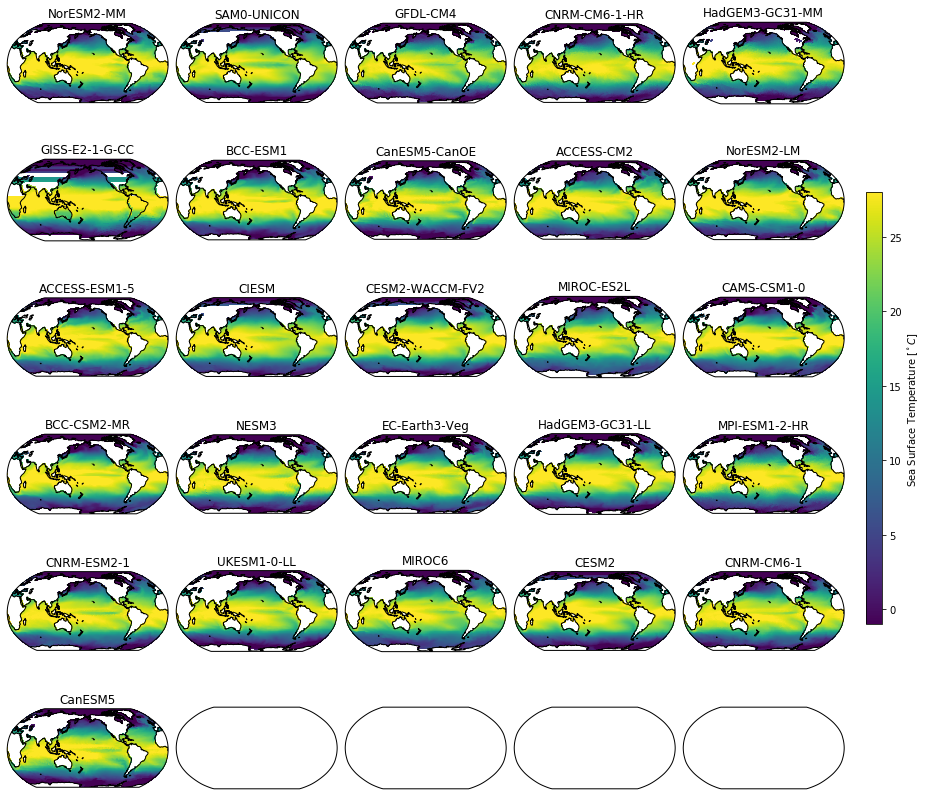

In [176]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, axarr = plt.subplots(
    ncols=5, nrows=6, figsize=[15, 15], subplot_kw={"projection": ccrs.Robinson(190)}
)
for ax, (k, ds) in zip(axarr.flat, ddict_pp.items()):
    # Select a single member for each model
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=-1)

    # select the first time step
    da = ds.tos.isel(time=0)
    
    # some models have large values instead of nans, so we mask unresonable values
    da = da.where(da < 1e30)
    
    # and plot the resulting 2d array using xarray
    pp = da.plot(
        ax=ax,
        x="lon",
        y="lat",
        vmin=-1,
        vmax=28,
        transform=ccrs.PlateCarree(),
        infer_intervals=False,
        add_colorbar=False,
    )
    
    ax.set_title(ds.attrs['source_id'])
    ax.coastlines()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Temperature [$^\circ C$]")

That was very little code to plot such a comprehensive figure, even if the models all have different resolution and grid architectures.


`cmip6_preprocessing` helps keeping the logic needed for simple analysis and visualization to a minimum, but in the newest version is also helps to facilitate the use of [`xgcm`](https://github.com/xgcm/xgcm) with the native model grids, making it a powerful tool for more complex analysis across the models.

## Calculations on native model grids using `xgcm`.

Most modern circulation models discretize the partial differential equations needed to simulate the earth system on a logically [rectangular grid](https://xgcm.readthedocs.io/en/latest/grids.html). This means the grid for a single time step can be represented as a 3-dimensional array of cells. Operations like e.g., a derivative are then approximated by a finite difference between neighboring cells, divided by the appropriate distance.

Calculating operators like *gradient*, *curl* or *divergence* is usually associated with a lot of bookkeeping to make sure that the difference is taken between the correct grid points, etc. This often leads to users preferring interpolated grids (on regular lon/lat grids), which have to be processed and stored next to the native grid data, both increasing storage requirements and potentially losing some of the detailed structure in the high-resolution model fields.

The combination of `cmip6_preprocessing` and `xgcm` enables the user to quickly calculate operators like *gradient* or *curl* (shown in detail below) on the native model grids, preserving the maximum detail the models provide and preventing unnecessary storage burden. `cmip6_preprocessing` parses the detailed grid information for the different models so that `xgcm` can carry out the computations, without requiring the user to dive into the details of each model grid.

As an example, let us compute and plot the gradient magnitude of the SST.

$ \overline{\nabla(SST)} = \sqrt{\frac{\partial SST}{\partial x}^2 + \frac{\partial SST}{\partial y}^2} $

We will start with an example of just computing the zonal gradient $\frac{\partial SST}{\partial x}$:

First, we need to create a suitable grid, with dimensions both for the cell center (where our tracer is located) and the cell faces. These are needed for xgcm to calculate the finite distance version of the above equation. 

The function `combine_staggered_grid` parses a dataset so that it is compatible with xgcm. It also provides a 'ready-to-use' [xgm Grid object](https://xgcm.readthedocs.io/en/latest/grids.html#creating-grid-objects) for convenience.

In [196]:
# we pick one of the many models
ds = ddict_pp['CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.Omon.gn']
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, y: 1050)
Coordinates:
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * bnds           (bnds) int64 0 1
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 20, 1050, 1442), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM6-1-HR
    source_type:             AOGCM
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    title:                   CNRM-CM6-1-HR model output prepared for CMIP6 an...
    tracking_id:             hdl:21.14100/ea182917-b175-4bbd-bb83-f127d71fa772
    variable_id:             tos
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    intake_esm_varname:      tos
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.Omon.gn

In [197]:
# Now we parse the necessary additional dimensions
grid,ds = combine_staggered_grid(ds)
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, x_left: 1442, y: 1050, y_right: 1050)
Coordinates:
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    time_bounds    (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 1050, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat            (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * bnds           (bnds) int64 0 1
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
  * x_left         (x_left) float32 0.125 0.375 0.625 ... 359.625 359.875
  * y_right        (y_right) float32 -78.08345 -78.03601 ... 89.97394 90.02606
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 20, 1050, 1442), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM6-1-HR
    source_type:             AOGCM
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    title:                   CNRM-CM6-1-HR model output prepared for CMIP6 an...
    tracking_id:             hdl:21.14100/ea182917-b175-4bbd-bb83-f127d71fa772
    variable_id:             tos
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    intake_esm_varname:      tos
    intake_esm_dataset_key:  

Note how the new dimensions `x_left` and `y_right` are added, which are associated with the 'eastern' and 'northern' cell faces. 
We can now easily calculate the finite difference in the logical `X` direction:

In [198]:
delta_t_x = grid.diff(ds.tos, 'X')
delta_t_x

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1, 1980, 1050, 1442)","(1, 20, 1050, 1441)"
Count,1486 Tasks,198 Chunks
Type,float32,numpy.ndarray


This array is now located on the center of the eastern cell face. But in order to recreate a derivative, we need to divide this difference by an appropriate distance. Usually these distances are provided with model output, but currently there is no such data publicly available for CMIP models. 

To solve this problem, `cmip6_preprocessing` can recalculate grid distances.
> Be aware that this can lead to rather large biases when the grid is strongly warped, usually around the Arctic. More on that at the end of the notebook.

In [199]:
grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)

In [200]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1442, x_left: 1442, y: 1050, y_right: 1050)
Coordinates:
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    time_bounds    (bnds, time) float64 dask.array<chunksize=(2, 1980), meta=np.ndarray>
    lat_bounds     (y, x, bnds) float32 dask.array<chunksize=(1050, 1442, 1), meta=np.ndarray>
    lon_bounds     (y, x, bnds) float32 dask.array<chunksize=(1050, 1442, 1), meta=np.ndarray>
    lon            (y, x) float32 1.4255313 1.672195 ... 73.60567 73.59864
    lat            (y, x) float32 -78.02738 -78.02127 ... 80.2718 80.15926
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * x              (x) float32 0.25 0.5 0.75 1.0 ... 359.25 359.5 359.75 360.0
  * bnds           (bnds) int64 0 1
  * time           (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * y              (y) float32 -78.107124 -78.05977 -78.01226 ... 89.94787 90.0
  * member_id      (member_id) <U8 'r1i1p1f2'
  * x_left         (x_left) float32 0.125 0.375 0.625 ... 359.625 359.875
  * y_right        (y_right) float32 -78.08345 -78.03601 ... 89.97394 90.02606
    dx_t           (y, x) float32 0.0 0.0 0.0 ... 12525.213 12526.91 12527.76
    dy_t           (y, x) float32 0.0 0.0 0.0 ... 11416.201 11413.054 11409.701
    dx_gy          (y_right, x) float32 0.0 0.0 0.0 ... 12526.062 12527.76
    dy_gx          (y, x_left) float32 0.0 0.0 0.0 ... 11411.036 11407.741
    dx_gx          (y, x_left) float32 5695.537 5695.9785 ... 12526.91 12526.91
    dy_gy          (y_right, x) float32 0.0 0.0 0.0 ... 18432876.0 18439940.0
Data variables:
    tos            (y, x, member_id, time) float32 dask.array<chunksize=(1050, 1442, 1, 20), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-CM6-1-HR_historical_r1i1p1f2
    activity_id:             CMIP
    arpege_minor_version:    6.3.3
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    contact:                 contact.cmip@meteo.fr
    creation_date:           2019-05-23T13:08:54Z
    data_specs_version:      01.00.21
    description:             CMIP6 historical
    dr2xml_md5sum:           45d4369d889ddfb8149d771d8625e9ec
    dr2xml_version:          1.16
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           2
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFAC...
    grid:                    native ocean tri-polar grid with 1.47 M ocean cells
    grid_label:              gn
    history:                 none
    initialization_index:    1
    institution:             CNRM (Centre National de Recherches Meteorologiq...
    institution_id:          CNRM-CERFACS
    license:                 CMIP6 model data produced by CNRM-CERFACS is lic...
    mip_era:                 CMIP6
    nemo_gelato_commit:      84a9e3f161dade7_8250e198106a168
    nominal_resolution:      25 km
    parent_activity_id:      C M I P
    parent_experiment_id:    p i C o n t r o l
    parent_mip_era:          CMIP6
    parent_source_id:        CNRM-CM6-1-HR
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_variant_label:    r1i1p1f2
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              http://www.umr-cnrm.fr/cmip6/references
    source:                  CNRM-CM6-1-HR (2017):  aerosol: prescribed month...
    source_id:               CNRM-CM6-1-HR
    source_type:             AOGCM
    status:                  2020-05-09;created; by gcs.cmip6.ldeo@gma

Now there are additional coordinates, representing distances in the x and y direction at different grid locations. We can now calculate the derivative with respect to x

In [201]:
dt_dx = grid.diff(ds.tos, 'X') / ds.dx_gx
dt_dx

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1050, 1442, 1, 1980)","(1050, 1441, 1, 20)"
Count,1789 Tasks,198 Chunks
Type,float32,numpy.ndarray


`xgcm` can handle these cases even smarter, by automatically picking the right [grid metric](https://xgcm.readthedocs.io/en/latest/grid_metrics.html), in this case the zonal distance.

In [202]:
dt_dx_auto = grid.derivative(ds.tos, 'X')
dt_dx_auto

,Array,Chunk
Bytes,11.99 GB,121.04 MB
Shape,"(1050, 1442, 1, 1980)","(1050, 1441, 1, 20)"
Count,1789 Tasks,198 Chunks
Type,float32,numpy.ndarray


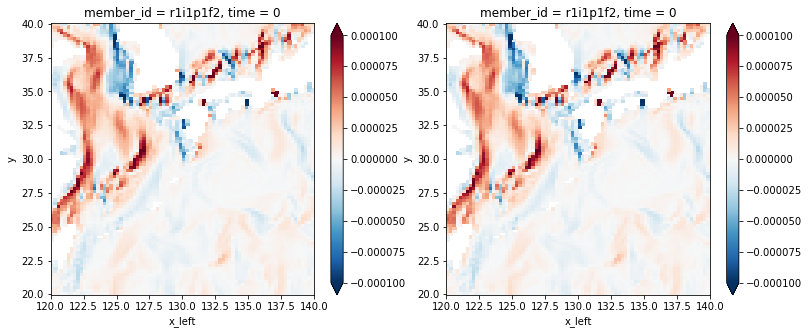

In [204]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[13,5])
dt_dx.isel(time=0).sel(x_left=slice(120, 140), y=slice(20,40)).plot(ax=ax1, vmax=1e-4)
dt_dx_auto.isel(time=0).sel(x_left=slice(120, 140), y=slice(20,40)).plot(ax=ax2, vmax=1e-4)

The results are identical, and the user does not have to remember the names of the distance coordinates, `xgcm` takes care of it. The derivative in the y-direction can be calculated similarly.

Then, let's compute the full gradient amplitude for **all** the models in one loop, averaging the values over all members and 5 years at the beginning of the historical period.

In [ ]:
fig, axarr = plt.subplots(
    ncols=4, nrows=7, figsize=[15, 15], subplot_kw={"projection": ccrs.Robinson(190)}
)
for ax, (k, ds) in zip(axarr.flat, ddict_pp.items()):
    
    # the cmip6_preprocessing magic: 
    # create an xgcm grid object and dataset with reconstructed grid metrics
    grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
    
    da = ds.tos

    # some models have large values instead of nans, so we mask unresonable values
    da = da.where(da < 1e30)

    # calculate the zonal temperature gradient
    dt_dx = grid.derivative(da, 'X')
    dt_dy = grid.derivative(da, 'Y', boundary='extend')
    # these values are now situated on the cell faces, we need to 
    # interpolate them back to the center to combine them

    dt_dx = grid.interp(dt_dx, 'X')
    dt_dy = grid.interp(dt_dy, 'Y', boundary='extend')
    grad = (dt_dx**2 + dt_dy**2)**0.5

    ds['grad'] = grad

    # take an average over the first 5 years of the run
    ds = ds.isel(time=slice(0,12*5)).mean('time', keep_attrs=True)

    # take the average over all available model members
    if "member_id" in ds.dims:
        ds = ds.mean('member_id', keep_attrs=True)

    # and plot the resulting 2d array using xarray
    pp = ds.grad.plot(
        ax=ax,
        x="lon",
        y="lat",
        vmin=1e-9,
        vmax=1e-5,
        transform=ccrs.PlateCarree(),
        infer_intervals=False,
        add_colorbar=False,
    )
    ax.set_title(ds.attrs['source_id'])
    ax.coastlines()
    
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Temperature gradient magnitude [$^\circ C/m$]")

Not bad for five additional lines of code! 

Features like the western boundary currents and the fronts across along the Antarctic Circumpolar Current are present in most models, and the equatorial region generally appears as a minimum in SST gradient.

## Calculate surface vorticity in the North Atlantic

But this was still just operating on a tracer field. What about velocity fields? We can also combine different variables into an xgcm compatible dataset!

The recommended workflow is to first load datasets seperately for each desired variable:

In [ ]:
variables = ['thetao', 'uo', 'vo']
ddict_multi = {var:{} for var in variables}
for var in variables:
    cat_var = col.search(table_id='Omon',
                         grid_label='gn',
                         experiment_id='historical',
                         variable_id=var,
                         source_id=models)

    ddict_multi[var] = cat_var.to_dataset_dict(
        zarr_kwargs={'consolidated':True, 'decode_times':False},
        preprocess=combined_preprocessing
    )

Now we need to make sure to choose only the intersection between the keys of each sub-dictionary, because we need all 3 variables for each model.

In [ ]:
ddict_multi_clean = {var:{} for var in variables}
for k in ddict_multi['thetao']:
    if all([k in ddict_multi[var] for var in variables]) and 'lev' in ddict_multi['thetao'][k].dims:
        for var in variables:
            ddict_multi_clean[var][k] = ddict_multi[var][k]

And now similar as before we can create a complete grid dataset, but we can pass additional datasets to be combined using the `other_ds` argument.  This can be a list of different variables, `cmip6_preprocessing` automatically detects the appropriate grid position.

In [ ]:
import matplotlib.path as mpath
import numpy as np

fig, axarr = plt.subplots(
    ncols=4, nrows=6, figsize=[25, 20], subplot_kw={"projection": ccrs.PlateCarree()}
)
for ai ,(ax, k) in enumerate(zip(axarr.flat, ddict_multi_clean['thetao'].keys())):
    ds_t = ddict_multi_clean['thetao'][k] # One tracer should always be the reference dataset!
    ds_u = ddict_multi_clean['uo'][k]
    ds_v = ddict_multi_clean['vo'][k]

    if 'lev' in ds_t: # show only models with depth coordinates in the vertical
        # aling only the intersection of the member_ids
        ds_t, ds_u, ds_v = xr.align(ds_t, ds_u, ds_v, join='inner', exclude=[di for di in ds_t.dims if di != 'member_id'])

        # combine all datasets and create grid with metrics
        grid, ds = combine_staggered_grid(ds_t, other_ds=[ds_u, ds_v], recalculate_metrics=True)


        # make new metric (this should be done behind the scenes...)
        ds.coords['dx_temp'] = grid.interp(ds['dx_gx'], 'Y', boundary='extend')
        ds.coords['dy_temp'] = grid.interp(ds['dy_gy'], 'X')
        from xgcm import Grid
        grid = Grid(ds, periodic=['X'], metrics={'X':[co for co in ds.coords if 'dx' in co],
                                                'Y':[co for co in ds.coords if 'dy' in co]})


        dv_dx = grid.derivative(ds.vo, 'X')
        du_dy = grid.derivative(ds.uo, 'Y',boundary='extend')

        # check the position of the derivatives and interpolate back to tracer point for plotting
        if any(['x_' in di for di in dv_dx.dims]):
            dv_dx = grid.interp(dv_dx, 'X')
        if any(['y_' in di for di in dv_dx.dims]):
            dv_dx = grid.interp(dv_dx, 'Y', boundary='extend')

        if any(['x_' in di for di in du_dy.dims]):
            du_dy = grid.interp(du_dy, 'X')
        if any(['y_' in di for di in du_dy.dims]):
            du_dy = grid.interp(du_dy, 'Y', boundary='extend')

        curl = dv_dx - du_dy

        ds['curl'] = curl

        ds = ds.isel(time=10)

        # take the average over all available model members
        if "member_id" in ds.dims:
            ds = ds.isel(member_id=0)

        # pick surface values
        ds = ds.isel(lev=0)
        
        ds = ds.sel(x=slice(270,335), y=slice(10,55))

        # and plot the resulting 2d array using xarray
        pp = ds.curl.plot.contourf(
            levels=51,
            ax=ax,
            x="lon",
            y="lat",
            vmax=1e-5,
            transform=ccrs.PlateCarree(),
            infer_intervals=False,
            add_colorbar=False,
            add_labels=False
        )
        ax.text(0.2,0.9,ds.attrs['source_id'],horizontalalignment='center',verticalalignment='center',
                transform=ax.transAxes, fontsize=10)
        ax.coastlines()
        ax.set_extent([-90, -45, 20, 45], ccrs.PlateCarree())
fig.subplots_adjust(wspace=0.01, hspace=0.01)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
fig.colorbar(pp, cax=cbar_ax, label="Sea Surface Vorticity [$1/s$]")

## A caveat: Reconstructed metrics

For all the examples shown here, we have relied on a simplified reconstruction of the grid metrics (in this case, the distances between different points on the grid). We can check the quality of the reconstruction indirectly by comparing these to the only horizontal grid metric that is saved with the ocean model output: The horizontal grid cell area.

We reconstruct our area naively as the product of the x and y distances centered on the tracer cell, `dx_t`, and `dy_t`.

In [ ]:
ds = ddict_multi_clean['thetao']['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn']
_,ds = combine_staggered_grid(ds, recalculate_metrics=True)
area_reconstructed = ds.dx_t * ds.dy_t

Now lets load the actual area and compare the two.

In [ ]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
cat = col.search(table_id='Ofx', variable_id='areacello', source_id='GFDL-CM4' , grid_label='gn') # switch to `grid_label='gr'` for regridded file
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True}, preprocess=combined_preprocessing)
_,ds_area = ddict.popitem()
area = ds_area.areacello.isel(member_id=0).squeeze()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[20,5])
area_reconstructed.plot(ax=ax1, vmax=1e9)
area.plot(ax=ax2, vmax=1e9)
((area_reconstructed - area) / area * 100).plot(ax=ax3, vmax=0.5)
ax1.set_title('reconstructed area')
ax2.set_title('saved area')
ax3.set_title('difference in %')

You can see that for this particular model (`GFDL-CM4`), the reconstruction does reproduce the grid area with a less than 0.5% error between approximately 60S-60N. North of that, the grid geometry gets vastly more complicated, and the simple reconstruction fails. The area over which the reconstruction varies from model to model and as such caution should always be exercised when analyzing data using reconstructed metrics.

At this point, this is, however, the only way to run these kinds of analyses, since the original grid metrics are not routinely provided with the CMIP6 output. In order to truly reproduce analyses like e.g., budgets, the community requires the native model geometry.

## Conclusions

We show that using `cmip6_preprocessing` and `xgcm` users can analyze complex native ocean model grids without the need to interpolate data or keep track of the intricacies of single model grids. Using these tools already enables users to calculate common operators like the gradient and curl, [weighted averages](https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Grid-aware-(weighted)-average) and more, in a 'grid-agnostic' way, with decent precision outside of the polar regions.

Pending on the availability of more grid metric output and building on these tools, complex analyses like various budgets could become a matter of a few lines and be calculated across all models in the CMIP6 archive. 

By combining generalizable and reproducible analysis with the [publicly available CMIP6 data](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396), more users will be able to analyze the data efficiently, leading to faster understanding and synthesis of the vast amount of data provided by modern climate modeling. 